## Use principal component analysis and k-mean clustering to group similar cells

Goal is to group cells based on current clamp parameters like spike frequency, AP rise, early diastolic duration rate, etc, etc.

This allows us to group cells without specifying an arbitrary theshold in something like 'spike frequency'.

We can then use this model to predict if a new recording is in superior or inferior regions.

## This code is based on the following

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

https://realpython.com/k-means-clustering-python/

https://realpython.com/k-means-clustering-python/

A more low-level into without using high-level functions

https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-kmeans-clustering-pca-b7ba6fafa74

For a plotly version, see:

https://plotly.com/python/v3/ipython-notebooks/baltimore-vital-signs/

In [1]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import cdist # to plot a circle (of radius) around each cluster

from kneed import KneeLocator # to get automatic estimate of number of groups in inertia

from IPython.display import display

%config InlineBackend.figure_format='retina'

plt.style.use("fivethirtyeight")


## Load the summary csv table

- Remove some columns that are not actually current-clamp measurements
- Remove some columns that are intermediate calculations
- Convert other categorical columns like male/female sex to codes (e.g. numbers)

### Most important is to remove our original 'Region'

In [2]:
# Load in the data
path = 'apTable.csv'
df0 = pd.read_csv(path)
df = pd.read_csv(path)

#print('original table with all rows')
#display(df0)

print('IMPORTANT: DO NOT DROP BY ROW NUMBER -->> DROP BY FILE NAME')
# drop row 21, it is superior with n=5 spikes AND low frequency
df0 = df0.drop([df0.index[21]]) 
df = df.drop([df.index[21]]) 

# when I remove this, all my nice grouping goes away
# drop row 12, it is superior with
# - bad series resistance
# - almost no peak in dvdt
# - membrane potential is incredibly filtered
df0 = df0.drop([df0.index[12]]) 
df = df.drop([df.index[12]]) 

# 20200707_0001 is incredibly filtered
# the dvdt (in sanpy) is almost nothing
# the avg spike shape shows the filtering
# the access resistance of this cell is not acceptable -->> reject !!!
# drop row xxx, 20200707_0001, the series resistance is too high -->> FILTERED SPIKES

# remove some columns
dropColList = ['Unnamed: 0', 'index', 'n', 'Condition', 'analysisname']
df = df.drop(columns=dropColList)

# remove columns that are intermediate calculations
#dropColList = ['earlyDiastolicDuration_ms_mean', 'diastolicDuration_ms_mean']
#df = df.drop(columns=dropColList)

# remove region because this is what we want to predict
dropColList = ['Region']
df = df.drop(columns=dropColList)

# temporarily remove spikeFreq_hz_mean to see if we get the same groups
#dropColList = ['spikeFreq_hz_mean', 'cycleLength_ms_mean', 'spikeFreq_hz_cv']
#df = df.drop(columns=dropColList)

# drop all _std columns
for column in df.columns:
    if column.endswith('_std'):
        df = df.drop(columns=[column])

# convert categorical columns to numeric codes
#catColList = ['Region', 'Sex']
catColList = ['Sex']
for catCol in catColList:
    df[catCol] = df[catCol].astype('category')
    df[catCol] = df[catCol].cat.codes

print('remaining number of cells (rows):', len(df))
print('we are feeding the model with remaining number of parameters (columns):', len(df.columns))

display(df)


IMPORTANT: DO NOT DROP BY ROW NUMBER -->> DROP BY FILE NAME
remaining number of cells (rows): 22
we are feeding the model with remaining number of parameters (columns): 16


,Sex,spikeFreq_hz_mean,spikeFreq_hz_cv,cycleLength_ms_mean,thresholdVal_mean,peakVal_mean,peakHeight_mean,preMinVal_mean,postMinVal_mean,earlyDiastolicDurationRate_mean,earlyDiastolicDuration_ms_mean,diastolicDuration_ms_mean,preSpike_dvdt_max_val_mean,preSpike_dvdt_max_val2_mean,postSpike_dvdt_min_val_mean,apDuration_ms_mean
0,0,1.683259,0.555585,824.388889,-39.584073,22.144664,61.728738,-61.056641,-60.586548,32.676993,162.470000,406.140000,-3.878784,91.522218,11.605835,364.910000
1,0,1.440363,1.263966,1297.173485,-19.396882,12.859060,32.255941,-49.368832,-49.300230,12.636441,279.068421,697.615790,-6.915237,21.251332,8.587142,555.661654
2,0,1.359467,1.120855,5517.778333,-19.785563,-4.098075,15.687488,-67.814671,-67.849261,45.620060,858.660656,2146.595082,-18.014877,5.042905,-4.515601,3263.932787
3,1,2.248690,0.539323,657.169655,-18.603181,4.120500,22.723681,-64.134063,-64.168419,44.765471,154.620000,386.502759,-17.537716,27.183796,-0.375261,231.197241
4,1,2.522046,0.406240,734.729545,-39.954446,-22.725192,17.229254,-54.438421,-54.474224,62.470328,146.097727,365.195454,-27.524775,7.234053,-13.164867,357.197727
5,1,1.344800,0.738790,1634.417143,-19.829003,-4.269162,15.559841,-57.001580,-56.804606,52.441953,177.508333,443.722222,-18.478394,4.509820,-3.223843,1102.613889
6,1,1.983403,0.774051,1024.050000,-17.853115,11.162799,29.015914,-64.630047,-64.703064,44.456948,215.159783,537.852174,-13.263868,40.376083,5.592678,433.451087
7,0,4.193614,0.043080,238.801974,-19.814943,5.172729,24.987673,-58.064748,-58.115499,54.187526,38.375658,95.902632,-18.451289,4.690070,8.879210,131.660526
8,0,5.282270,0.044785,189.715476,-58.594840,16.394116,74.988956,-80.992969,-81.037481,194.888194,22.577381,56.386905,-20.996094,88.791620,11.935643,127.275000
9,0,4.792109,0.154835,213.877647,-18.643009,-3.028780,15.614229,-92.382554,-92.312464,42.648084,29.949412,74.812941,-18.615723,29.199937,-8.477783,114.850588


## To Do: Remove columns that are highly correlated (they are redundant)

For example 'ap duration' and 'cycle length' ... there are others ...

In [3]:
correlation = df.corr()
correlation.style.background_gradient(cmap='coolwarm')

,Sex,spikeFreq_hz_mean,spikeFreq_hz_cv,cycleLength_ms_mean,thresholdVal_mean,peakVal_mean,peakHeight_mean,preMinVal_mean,postMinVal_mean,earlyDiastolicDurationRate_mean,earlyDiastolicDuration_ms_mean,diastolicDuration_ms_mean,preSpike_dvdt_max_val_mean,preSpike_dvdt_max_val2_mean,postSpike_dvdt_min_val_mean,apDuration_ms_mean
Sex,1,-0.0770359,-0.0989059,-0.179918,0.238891,0.0795997,-0.158875,0.485541,0.483383,0.0925252,-0.191964,-0.191964,0.209421,-0.337583,0.189924,-0.171334
spikeFreq_hz_mean,-0.0770359,1,-0.836741,-0.603052,-0.395239,0.0855022,0.421606,-0.527949,-0.530607,0.595406,-0.635344,-0.635349,-0.40474,0.209951,0.00948605,-0.562114
spikeFreq_hz_cv,-0.0989059,-0.836741,1,0.729222,0.257215,-0.0973137,-0.304832,0.309459,0.311135,-0.585212,0.782713,0.782713,0.227535,-0.175572,-0.110903,0.673359
cycleLength_ms_mean,-0.179918,-0.603052,0.729222,1,0.159943,-0.221809,-0.307447,0.0929697,0.0933236,-0.345769,0.984495,0.984495,0.0572697,-0.27235,-0.186991,0.99315
thresholdVal_mean,0.238891,-0.395239,0.257215,0.159943,1,0.270875,-0.710609,0.50476,0.503672,-0.342648,0.163957,0.163956,0.712344,-0.345473,0.344972,0.149755
peakVal_mean,0.0795997,0.0855022,-0.0973137,-0.221809,0.270875,1,0.484797,0.287547,0.288776,0.234097,-0.207337,-0.207338,0.721711,0.553426,0.949304,-0.230388
peakHeight_mean,-0.158875,0.421606,-0.304832,-0.307447,-0.710609,0.484797,1,-0.24845,-0.246564,0.482433,-0.300516,-0.300516,-0.119724,0.718401,0.380419,-0.30446
preMinVal_mean,0.485541,-0.527949,0.309459,0.0929697,0.50476,0.287547,-0.24845,1,0.999962,-0.251953,0.121528,0.121532,0.635861,-0.319989,0.464699,0.0709861
postMinVal_mean,0.483383,-0.530607,0.311135,0.0933236,0.503672,0.288776,-0.246564,0.999962,1,-0.254715,0.121789,0.121793,0.637296,-0.31668,0.464974,0.0712922
earlyDiastolicDurationRate_mean,0.0925252,0.595406,-0.585212,-0.345769,-0.342648,0.234097,0.482433,-0.251953,-0.254715,1,-0.411665,-0.41167,-0.159455,0.231543,0.246065,-0.28818


## Standardize data and create principal components

We will then look at sequential principal components to decide how many to include to capture approximately 90% of the variation.

fit_transform gives us mean of 0 and Std of 1:
    new value = (value - mean) / SD
    


In [4]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)
scaled_features = X_std

# Create a PCA instance: pca
numComponents = scaled_features.shape[1] # must be <= the number of columns in our table
numComponents = 10
pca = PCA(n_components=numComponents)
principalComponents = pca.fit_transform(X_std)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

#display(PCA_components.head())

## Plot the explained variances

We are looking for the 'PCA feature' that takes a jump down and then all following values are asymptotically small.

To Do: Plot the cumuative histogram and select the number of PCA features that reach about 80% of the variance.

See: https://365datascience.com/pca-k-means/

It looks like we might include 3 PCA (0,1,2)


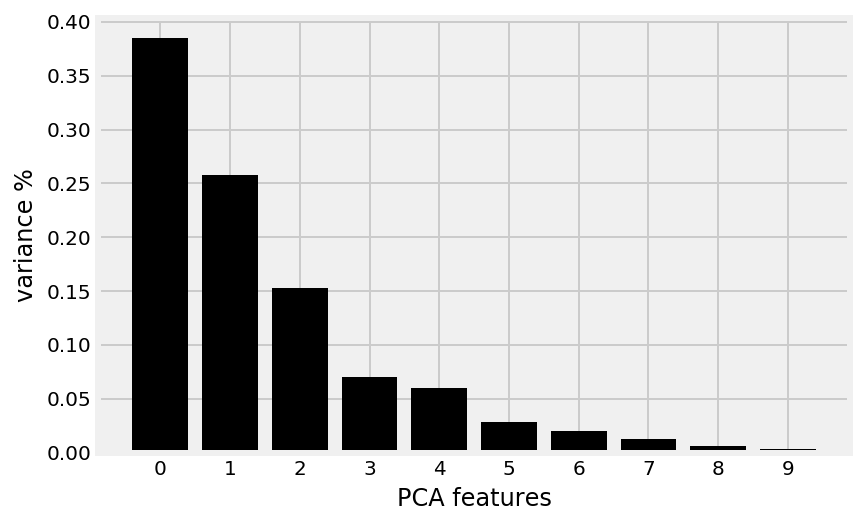

In [5]:
print('It looks like we might include 3 PCA (0,1,2)')

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features);


## Plot some of the PCA

Not very informative?

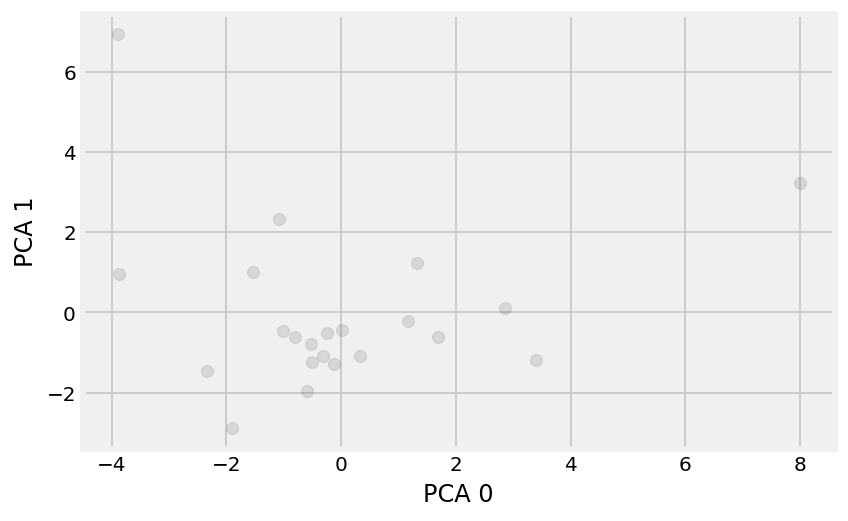

In [6]:
# plot the first 2 PC
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
plt.show()


# Run k-means clustering on the 1st n PC

Here we are looking for an inflection point or 'elbow' where the change in intertia becomes small.

We will also use the silhouette coefficient. Here we are looking for peaks.

This is usually at the 4th or 5th cluster. With this we would want to look at clusters 1-4 or 1-5.


In [7]:
numPCA = 2
maxClusters = 12

#
# run k-means clustering on the 1st three PC
ks0 = range(1, maxClusters)
inertias = []
for k in ks0:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components.iloc[:,:numPCA])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# determine knee point algorithmically
kl = KneeLocator(ks0, inertias, curve="convex", direction="decreasing")
print(f'Auto KneeLocator gives us {kl.elbow} cluster')

#
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Need to start at 2 clusters for silhouette coefficient
ks1 = range(2, maxClusters)
for k in ks1:
    kmeans = KMeans(n_clusters=k) #, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)


Auto KneeLocator gives us 4 cluster


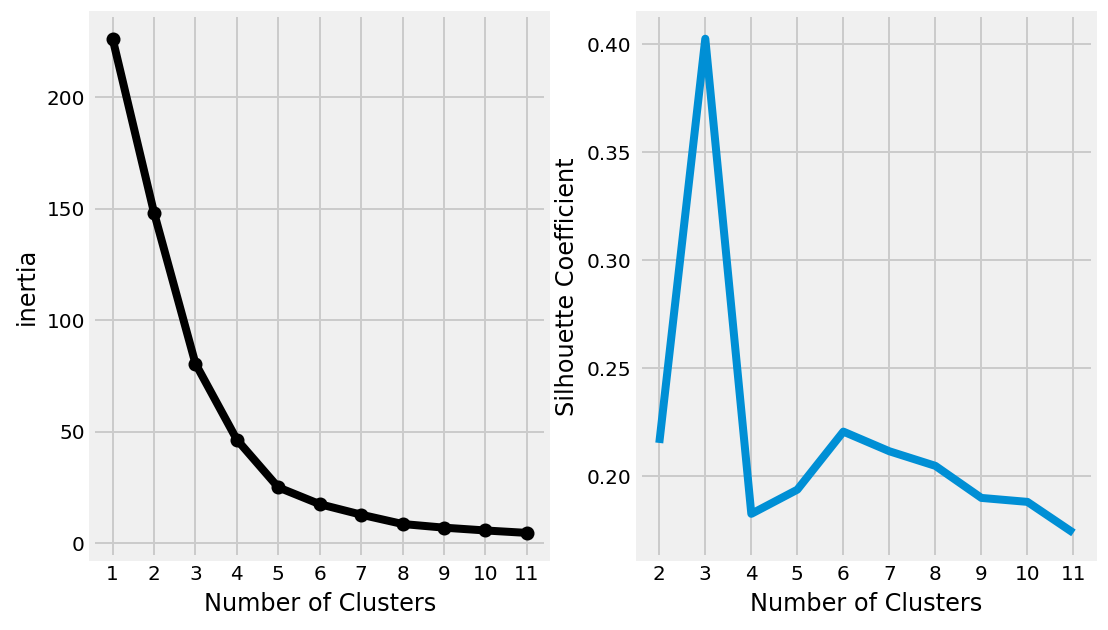

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharey=False)


#
# plot initerias
axs[0].plot(ks0, inertias, '-o', color='black')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('inertia')
axs[0].set_xticks(ks0)
#axs[0].show()

#
# plot silhouette_coefficients
axs[1].plot(ks1, silhouette_coefficients)
axs[1].set_xticks(ks1)
axs[1].set_xlabel("Number of Clusters")
axs[1].set_ylabel("Silhouette Coefficient");
#plt.show()


## Create final model with n_clusters and n_pca

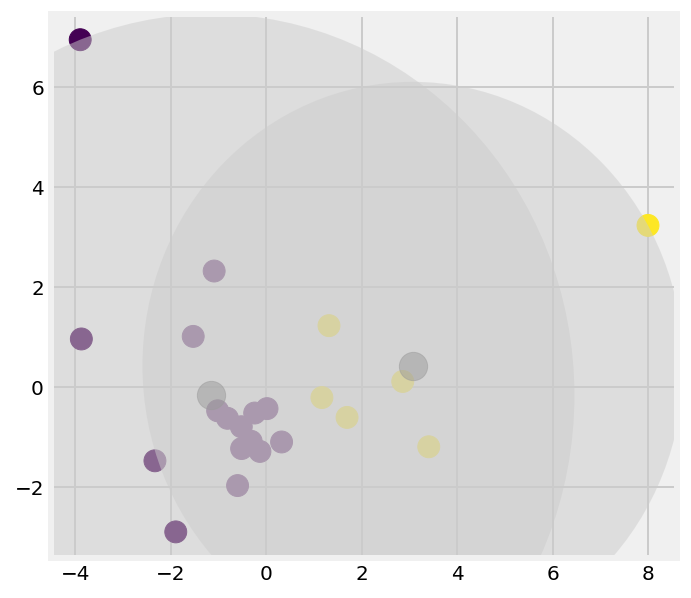

In [9]:
#display(PCA_components)

n_clusters = 2
model = KMeans(n_clusters=n_clusters)

n_pca = 2 # 2 will include pca 0 and pca 1
model.fit(PCA_components.iloc[:,:n_pca])

labels = model.predict(PCA_components.iloc[:,:n_pca])

fig, axs = plt.subplots(1, 1, figsize=(5,5), sharey=True)

axs.scatter(PCA_components[0], PCA_components[1], c=labels, s=120)

centers = model.cluster_centers_
axs.scatter(centers[:, 0], centers[:, 1], marker='o', c='black', s=200, alpha=0.5, facecolors='none');

# plot the representation of the KMeans model
# see: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
tmpX = PCA_components.iloc[:,:n_pca]
radii = [cdist(tmpX[labels == i], [center]).max()
         for i, center in enumerate(centers)]
for c, r in zip(centers, radii):
    axs.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
plt.show()


## To Do: Moving forward, we need to use a gaussian mixed model (GMM)

- GMM assigns probabilities to group membership (K-Means does not)
- GMM allows for 'stretched' groupings (K-Means is limited to circular groupings)

gaussianComponents: 2
gaussianNumPCA: 2


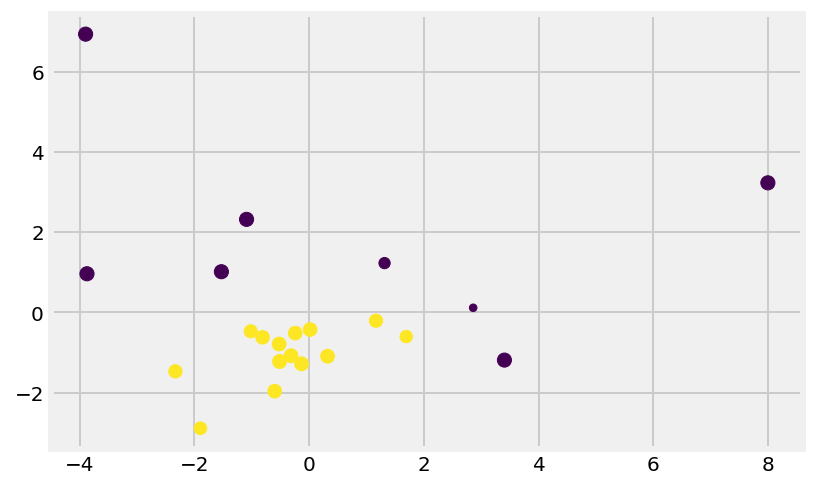

In [10]:
#from sklearn.mixture import GMM
gaussianComponents = 2
gaussianNumPCA = 2
print('gaussianComponents:', gaussianComponents)
print('gaussianNumPCA:', gaussianNumPCA)
X = PCA_components.iloc[:,:gaussianNumPCA]
#print(X)
#gmm = GMM(n_components=4).fit(X)
#labels = gmm.predict(X)

from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=gaussianComponents, covariance_type='full')
gmm.fit(PCA_components.iloc[:,:n_pca])
gaussianLabels = gmm.predict(X)

probs = gmm.predict_proba(X)
#print(probs[:5].round(3))

size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[0], X[1], c=gaussianLabels, cmap='viridis', s=size);

## Now take our grouping/labels that did not use original 'Region' and see how it predicts the original 'Region'

In [11]:
# make a new df with original Region (removed from analysis)
# and the prediction

labels2 = labels.tolist()
gaussianLabels2 = gaussianLabels.tolist()

finalDf = df0[['Region']].copy()
finalDf['Condition'] = df0[['Condition']]
finalDf['spikeFreq_hz_mean'] = df0[['spikeFreq_hz_mean']]
finalDf['spikeFreq_hz_cv'] = df0[['spikeFreq_hz_cv']]
finalDf['earlyDiastolicDurationRate_mean'] = df0[['earlyDiastolicDurationRate_mean']]
finalDf['preMinVal_mean'] = df0[['preMinVal_mean']]
finalDf['kMeans Group'] = labels2
finalDf['GMM Group'] = gaussianLabels2
finalDf['PCA0'] = PCA_components[0]
finalDf['PCA1'] = PCA_components[1]

#for tmpCol in df0.columns:
#    print(tmpCol)
    
#display(finalDf)

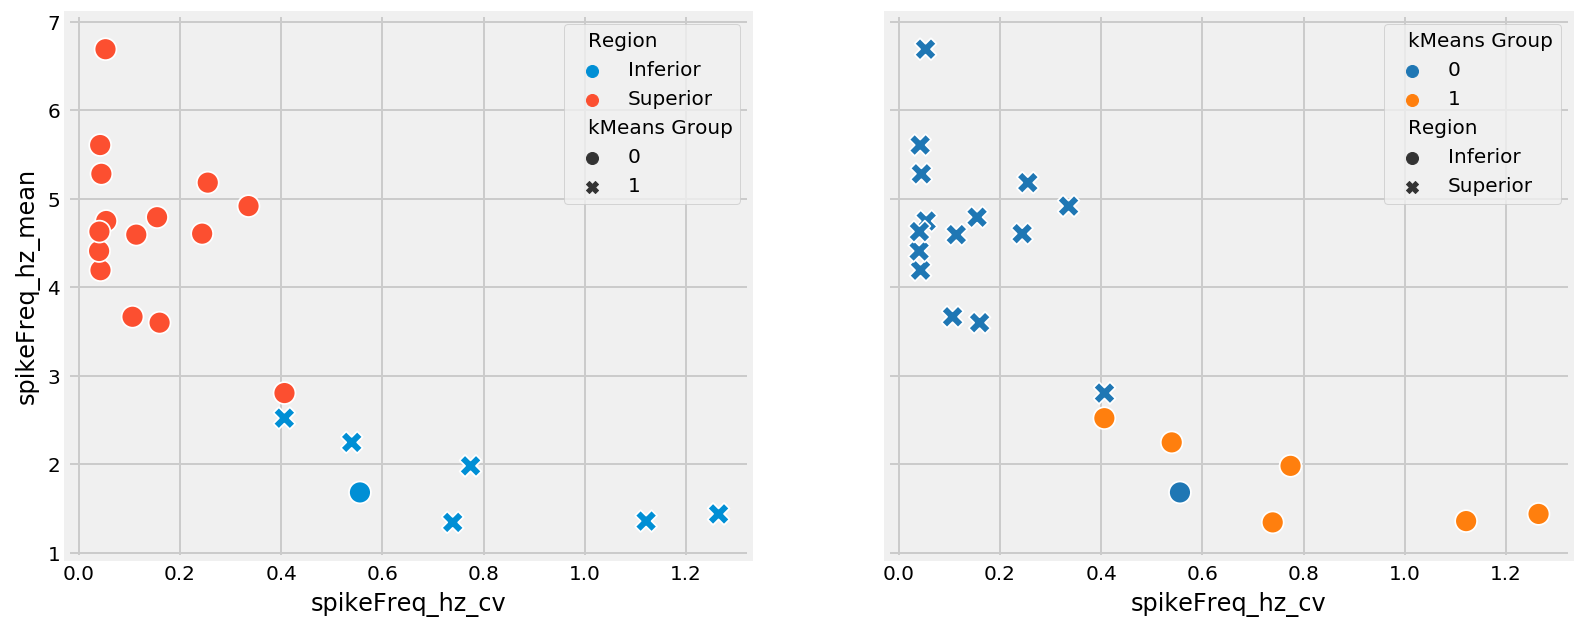

In [12]:
xStatStr = 'spikeFreq_hz_cv' #'earlyDiastolicDurationRate_mean' #preMinVal_mean
yStatStr = 'spikeFreq_hz_mean' #spikeFreq_hz_cv

s=120

fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

sns.scatterplot(x=xStatStr, y=yStatStr, style='kMeans Group', hue='Region', s=s, data=finalDf, ax=axs[0])

sns.scatterplot(x=xStatStr, y=yStatStr, style='Region', hue='kMeans Group', 
                palette='tab10', s=s, data=finalDf, ax=axs[1])

# gaussianLabels
#sns.scatterplot(x=xStatStr, y=yStatStr, style='Region', hue='GMM Group', 
#                palette='tab10', s=s, data=finalDf, ax=axs[1])


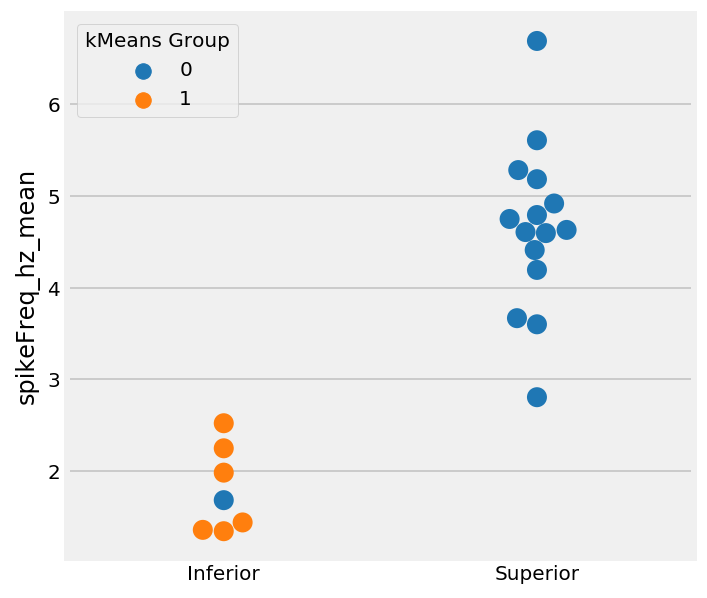

In [13]:
xZeros = [0 for x in range(len(finalDf))]
xZeros = finalDf['Region'].tolist()

#fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig, axs = plt.subplots(1, 1, figsize=(5,5), sharey=True)
axs = [axs]

sns.swarmplot(x=xZeros, y=yStatStr, hue='kMeans Group', 
              palette='tab10', s=10, data=finalDf, ax=axs[0])

#sns.swarmplot(x=xZeros, y=yStatStr, hue='Condition', 
#              palette='tab10', s=10, data=finalDf, ax=axs[1])


## Dendrogram

see: https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

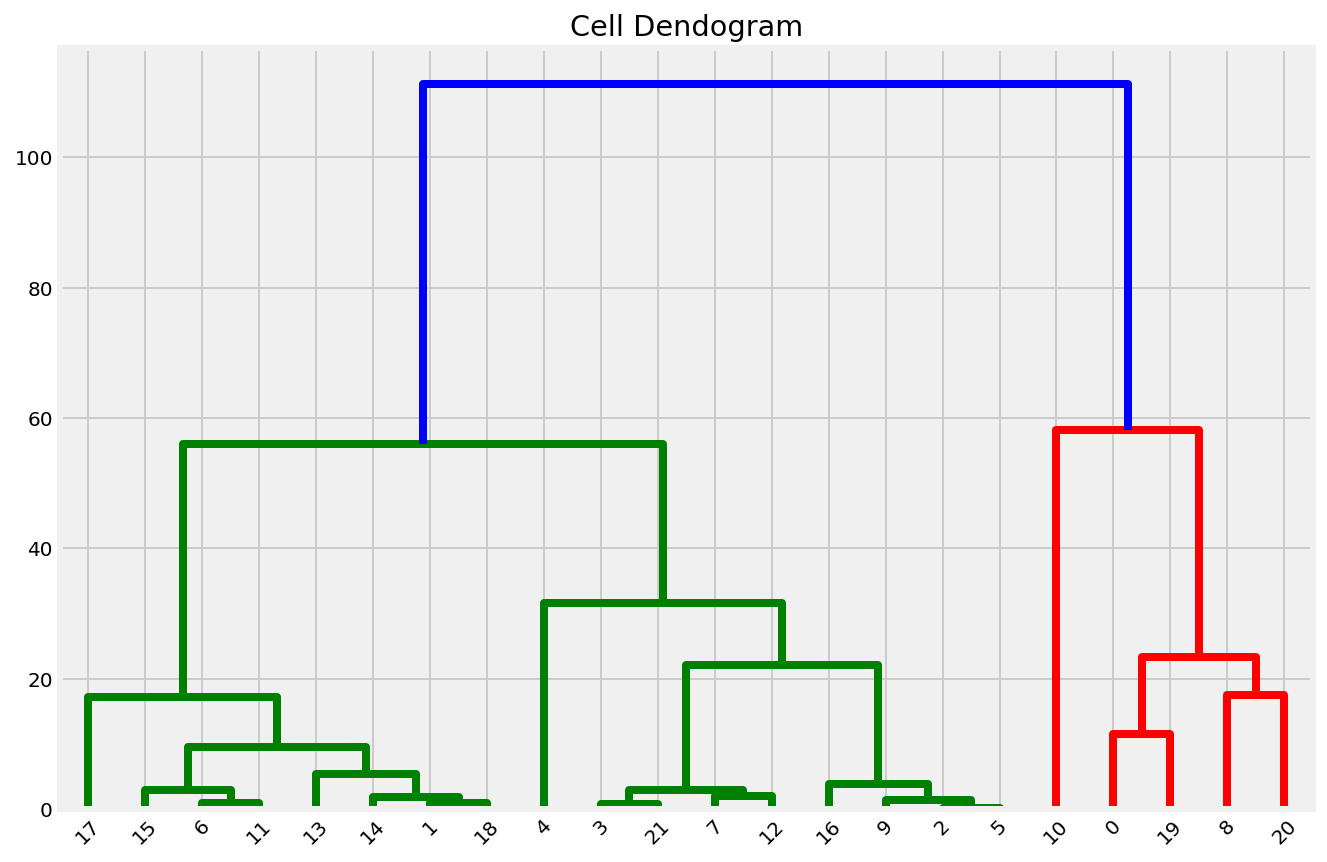

In [21]:
import scipy.cluster.hierarchy as shc

denData = df # gives just 1 cell then all other cells?
denData = df.iloc[:,5:7]

plt.figure(figsize=(10, 7))
plt.title("Cell Dendogram")
dend = shc.dendrogram(shc.linkage(denData, method='ward'))

## Generate average spike for each group

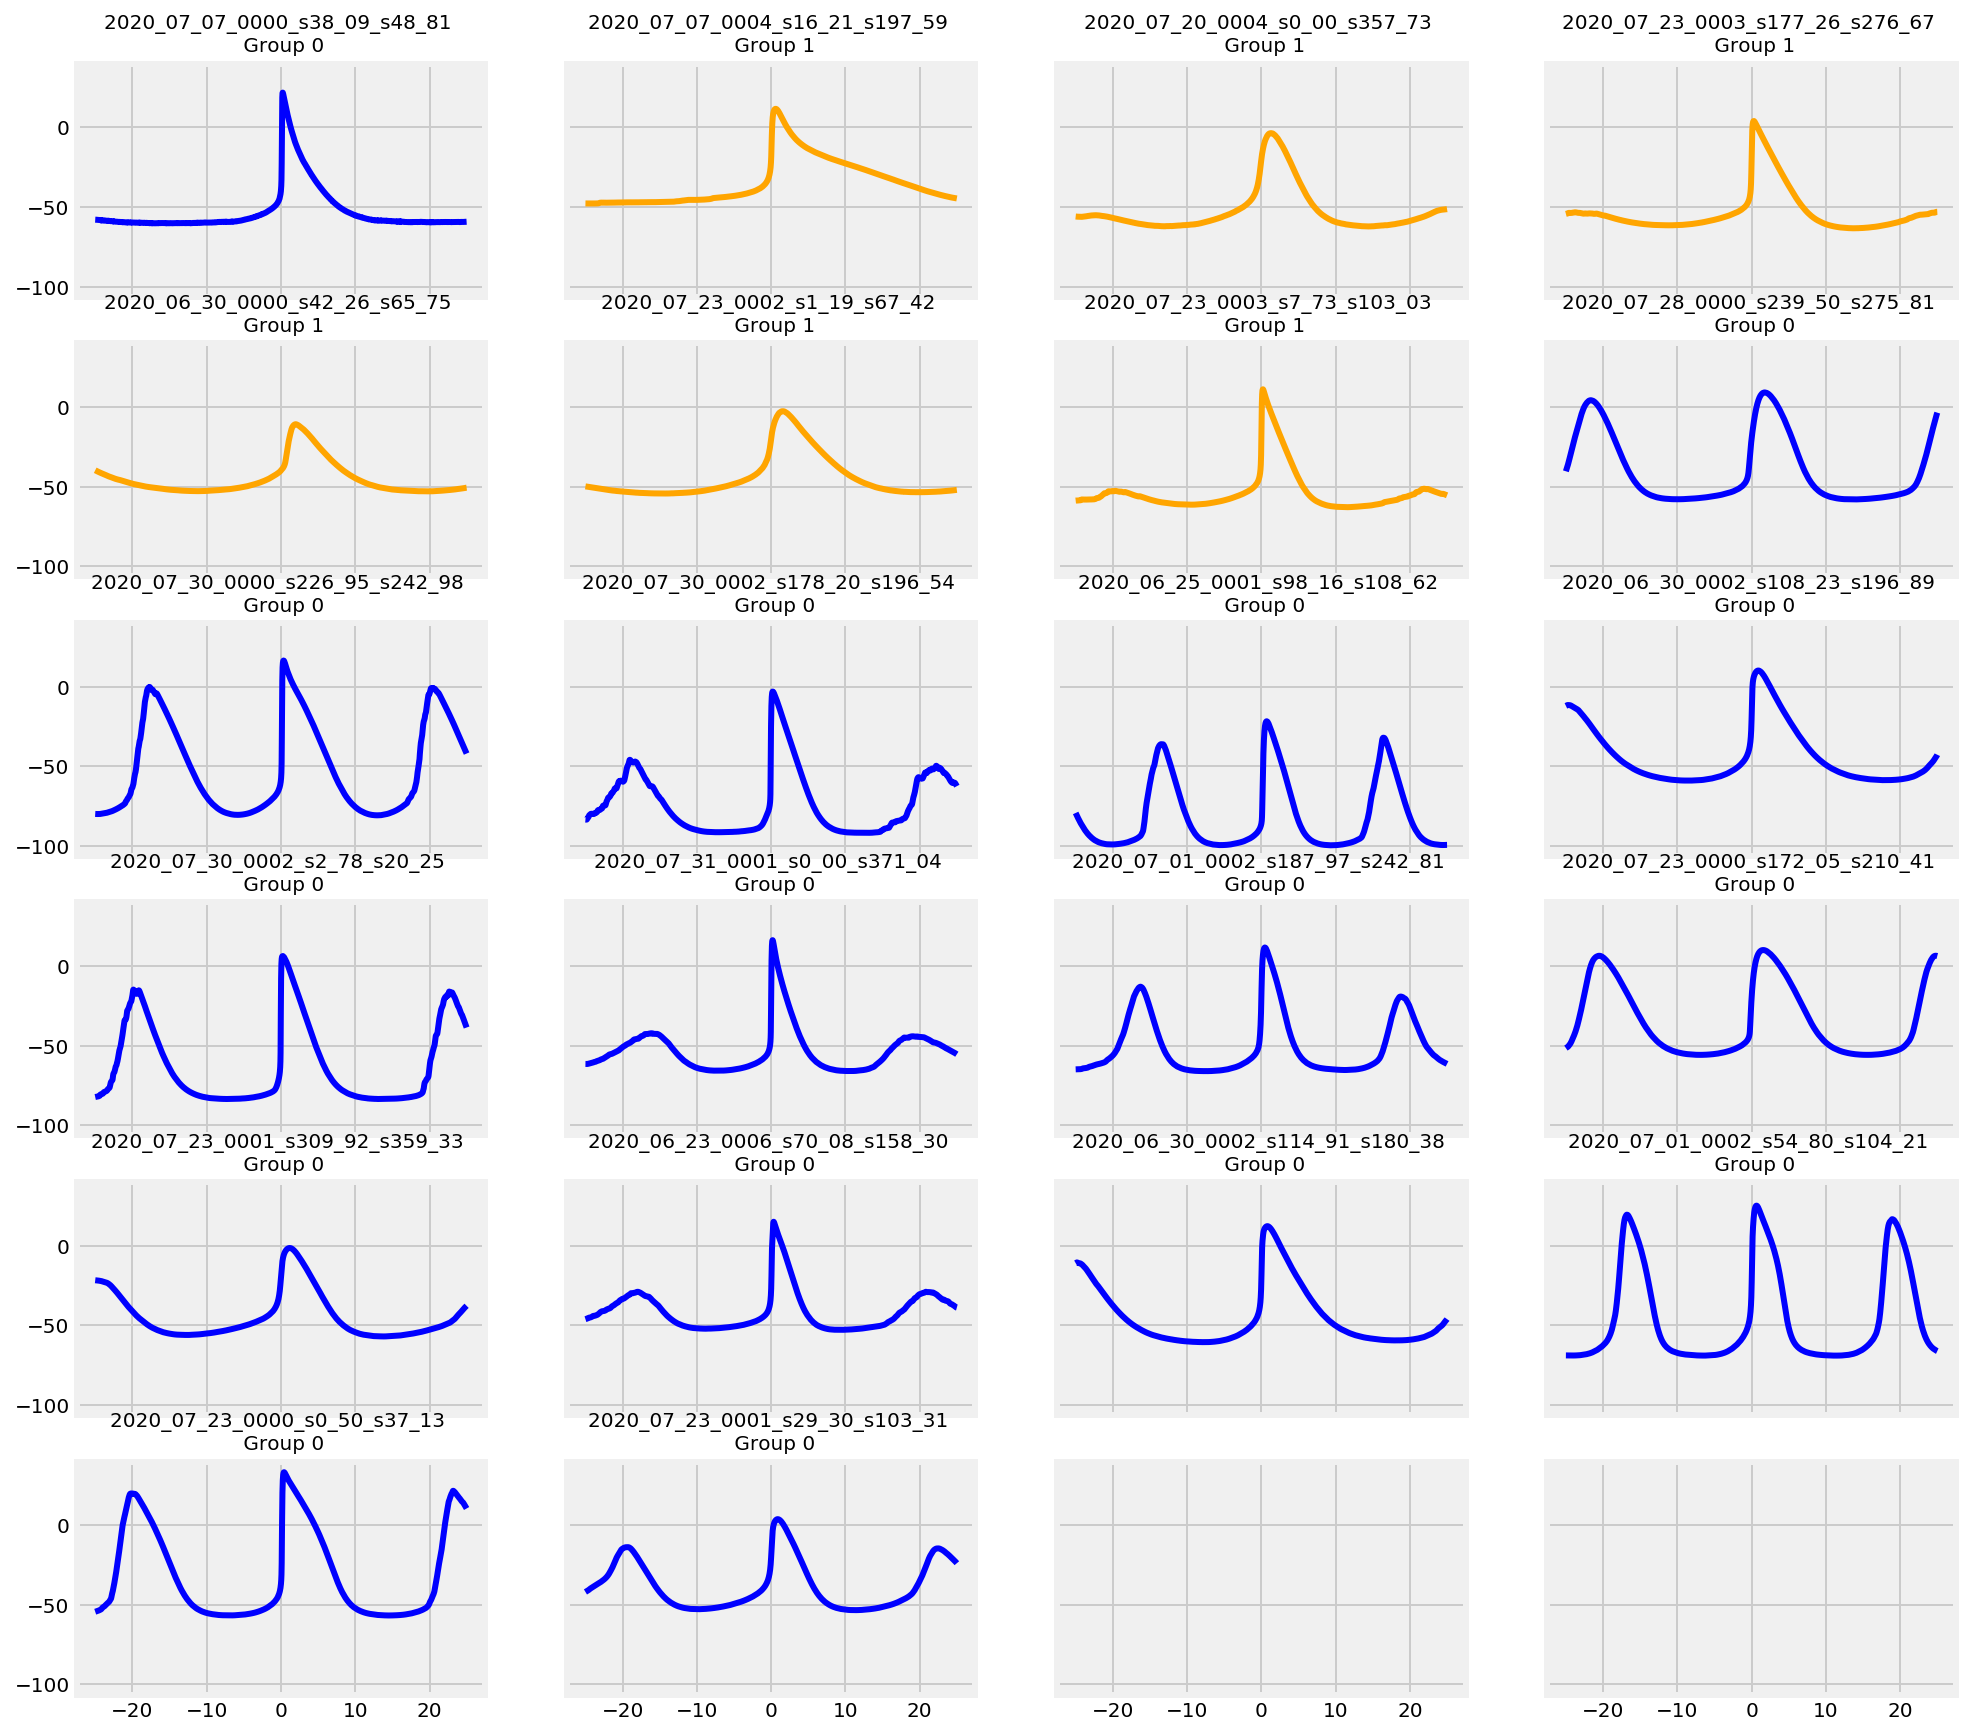

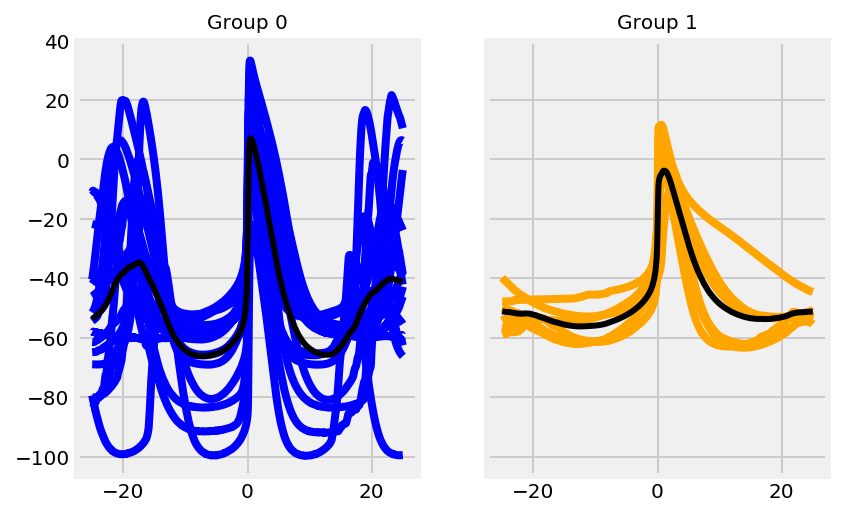

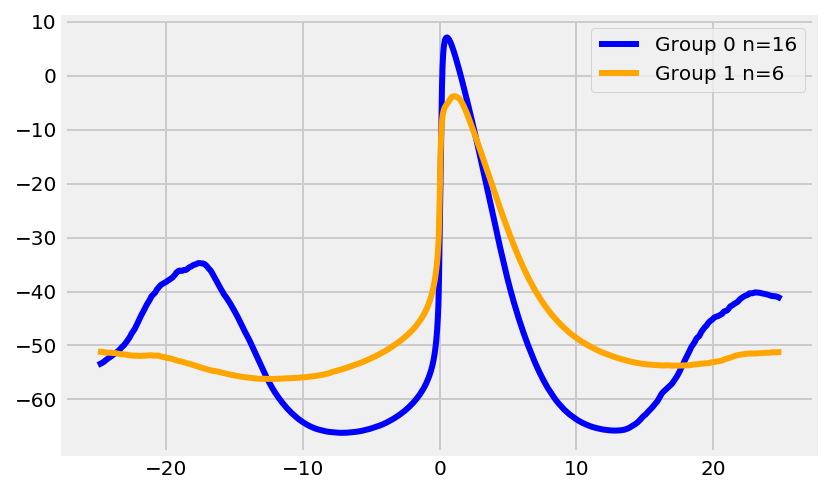

In [14]:
myColorList = ['blue', 'orange', 'r', 'g', 'b', 'c']

# /Users/cudmore/data/laura-ephys/SAN\ AP/NEWxxx/2020_06_30_0000_s42_26_s65_75_clip.csv 
analysisPath = '/Users/cudmore/data/laura-ephys/SAN AP/NEWxxx'

numCells = len(df0)

numGroups = 2
meanClipPerGroup = [None] * numGroups
xClipPerGroup = [None] * numGroups
numPerGroup = [0] * numGroups

linewidth = 3

numCol = 4
numRow = math.ceil(numCells/numCol)
fig0, axs0 = plt.subplots(numRow, numCol, sharey=True, sharex=True, figsize=(15,15))
axs0 = axs0.ravel()

fig, axs = plt.subplots(1, numGroups, sharey=True)

# load clips and make mean clip for each group
for i in range(numCells):
    analysisname = df0['analysisname'].iloc[i] # name with start/stop seconds
    kMeansGroup = finalDf['kMeans Group'].iloc[i]
    groupColor = myColorList[kMeansGroup]
        
    clipFileName = analysisname + '_clip.csv'
    clipFilePath = os.path.join(analysisPath, clipFileName)
    #print(clipFilePath)
    clipDf = pd.read_csv(clipFilePath)
    
    xMs = clipDf['xMs']
    yVm = clipDf['yVm']
    axs[kMeansGroup].plot(xMs, yVm, '-', c=groupColor)

    axs0[i].set_title(f'{analysisname} \n Group {kMeansGroup}', fontsize=10)
    axs0[i].plot(xMs, yVm, '-', c=groupColor, linewidth=linewidth)

    if meanClipPerGroup[kMeansGroup] is None:
        meanClipPerGroup[kMeansGroup] = yVm
        xClipPerGroup[kMeansGroup] = xMs
    else:
        meanClipPerGroup[kMeansGroup] += yVm
    numPerGroup[kMeansGroup] += 1
    
# To overlay Mean Clip Of Each group
fig2, axs2 = plt.subplots(1, 1)

tmpNumGroups = numGroups
tmpNumGroups = 2
for i in range(tmpNumGroups):
    groupColor = myColorList[i]
    nInGroup = numPerGroup[i]
    meanClipPerGroup[i] /= nInGroup
    
    axs[i].set_title(f'Group {i}', fontsize=10)
    axs[i].plot(xClipPerGroup[i], meanClipPerGroup[i], '-', c='k', linewidth=linewidth)
    
    axs2.plot(xClipPerGroup[i], meanClipPerGroup[i], '-', c=groupColor, linewidth=linewidth,
              label=f'Group {i} n={nInGroup}')

#
axs2.legend();
